## Classification Notes for Future Meeting (9/04/2024)
Notes for a future meeting - currently playing around with classification !

## Setup

In [186]:
import pathlib 
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics

import sys
sys.path.append(str(pathlib.Path.cwd().parents[0]/ "src" / "classify"))
sys.path.append(str(pathlib.Path.cwd().parents[0]/ "src" / "utils"))
from prepare_data import load_metrics, create_split
from pca import run_PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [187]:
path = pathlib.Path.cwd()

## Helper functions

In [188]:
# define function for getting and plotting feature importance
def show_feature_importances(clf, df):
    # check feature importance
    feature_importances_vals = clf.feature_importances_
    feature_importances = pd.DataFrame({"feature": splits["X_train"].columns, "importance": feature_importances_vals})

    # print sorted by importance
    print(feature_importances.sort_values(by="importance", ascending=False))

    # return plot 
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 15))
    g = sns.barplot(x="importance", y="feature", data=feature_importances.sort_values(by="importance", ascending=False))
    plt.title("Feature importances")
    
    return feature_importances, g

## Stories (Temp 1) Classification

In [189]:
# data 
datapath = path.parents[0] / "metrics"
dataset = "stories"
df = load_metrics(
                            human_dir=datapath / "human_metrics", 
                            ai_dir=datapath / "ai_metrics",
                            dataset=dataset, temp=1, 
                            human_completions_only=True
                            )


# print how many human and ai samples are in the dataset per temperature
print(df.groupby(["is_human"]).size())

[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
is_human
0    20000
1     5000
dtype: int64


In [190]:
clf = XGBClassifier(enable_categorical=True, use_label_encoder=False, random_state=129)

# drop doc length and pos_prop_space (some NAs in humans apparently) # see glossary for all pos tags https://github.com/explosion/spaCy/blob/master/spacy/glossary.py cols_to_drop = ["doc_length", "pos_prop_SPACE"]
cols_to_drop = ["pos_prop_SPACE"]

new_df = df.drop(cols_to_drop, axis=1)

# all features
splits = create_split(new_df, random_state=129, val_test_size=0.15, outcome_col="is_human", verbose=False)

clf.fit(splits["X_train"], splits["y_train"])

# eval
y_pred = clf.predict(splits["X_val"])
print(metrics.classification_report(splits["y_val"], y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3000
           1       0.99      0.98      0.98       750

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750



                                   feature  importance
56                  sentence_length_median    0.387539
27                               oov_ratio    0.091475
52                proportion_unique_tokens    0.043461
19                             gunning_fog    0.035728
5                  dependency_distance_std    0.033210
29                     per_word_perplexity    0.031579
57                     sentence_length_std    0.024544
9           duplicate_ngram_chr_fraction_5    0.023816
15                                 entropy    0.023632
20                                     lix    0.021798
53                                     rix    0.021007
58                                    smog    0.017059
0                              alpha_ratio    0.016105
17                    flesch_kincaid_grade    0.016093
50                proportion_bullet_points    0.014981
33                            pos_prop_ADV    0.012969
55                    sentence_length_mean    0.011589
45        

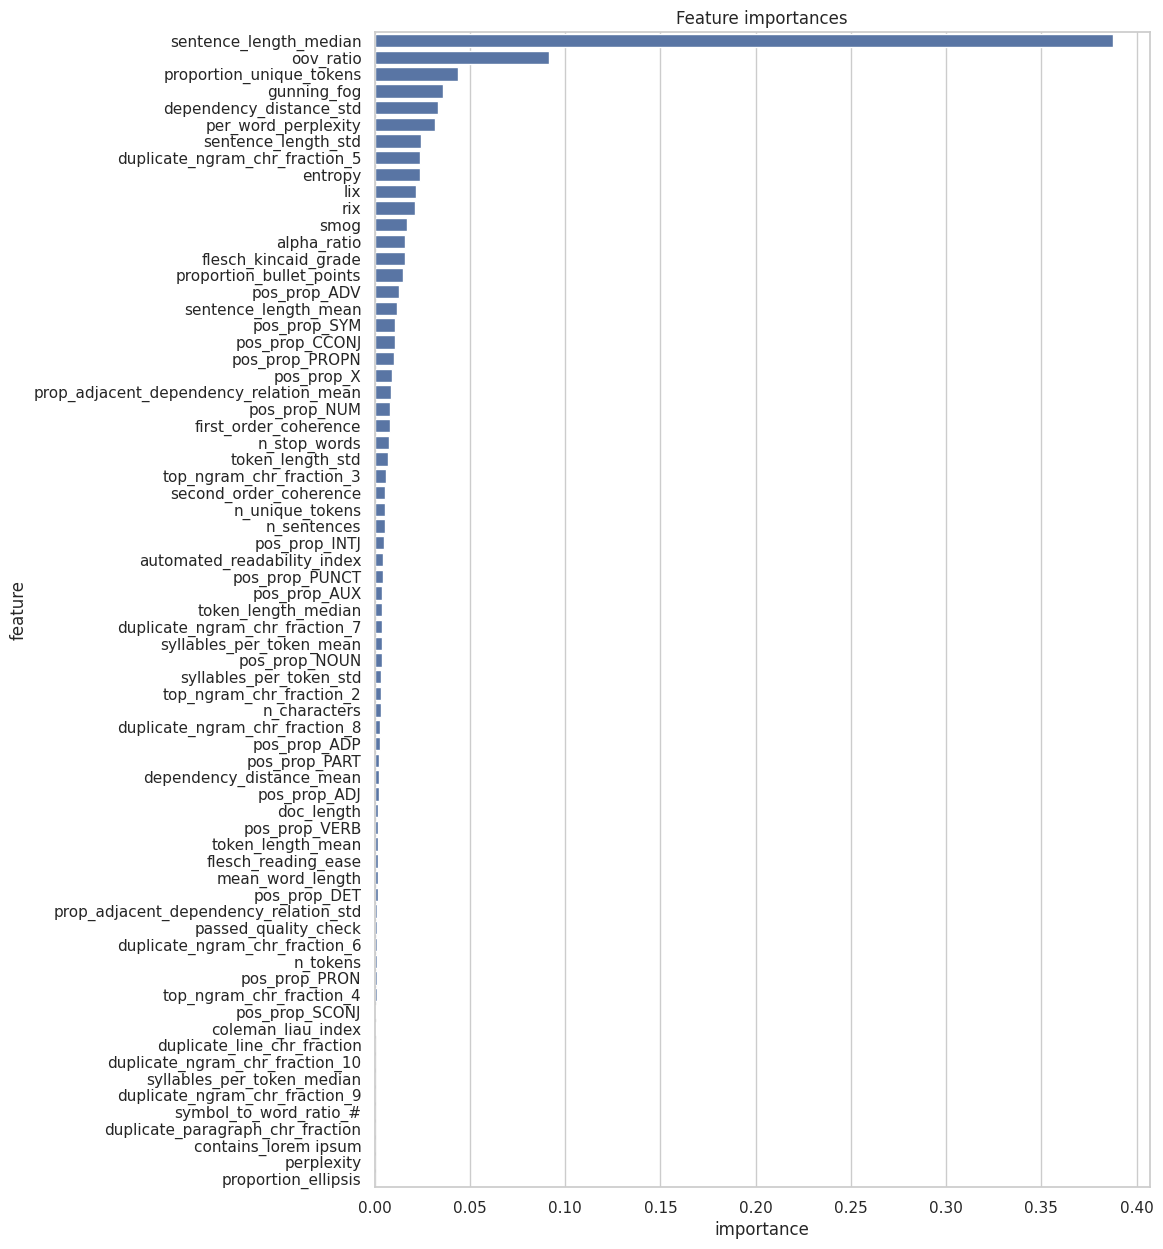

In [191]:
feature_importances, plot = show_feature_importances(clf, splits["X_train"])

In [192]:
features = ["proportion_unique_tokens", "alpha_ratio", "lix", "entropy", "per_word_perplexity"]
splits = create_split(df, random_state=129,
                        val_test_size=0.15, 
                        outcome_col="is_human", 
                        verbose=False, feature_cols=features
                        )

clf.fit(splits["X_train"], splits["y_train"])

# eval
y_pred = clf.predict(splits["X_val"])
print(metrics.classification_report(splits["y_val"], y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3000
           1       0.89      0.82      0.85       750

    accuracy                           0.94      3750
   macro avg       0.92      0.90      0.91      3750
weighted avg       0.94      0.94      0.94      3750



                    feature  importance
2                       lix    0.430217
0  proportion_unique_tokens    0.297669
1               alpha_ratio    0.126583
3                   entropy    0.092919
4       per_word_perplexity    0.052612


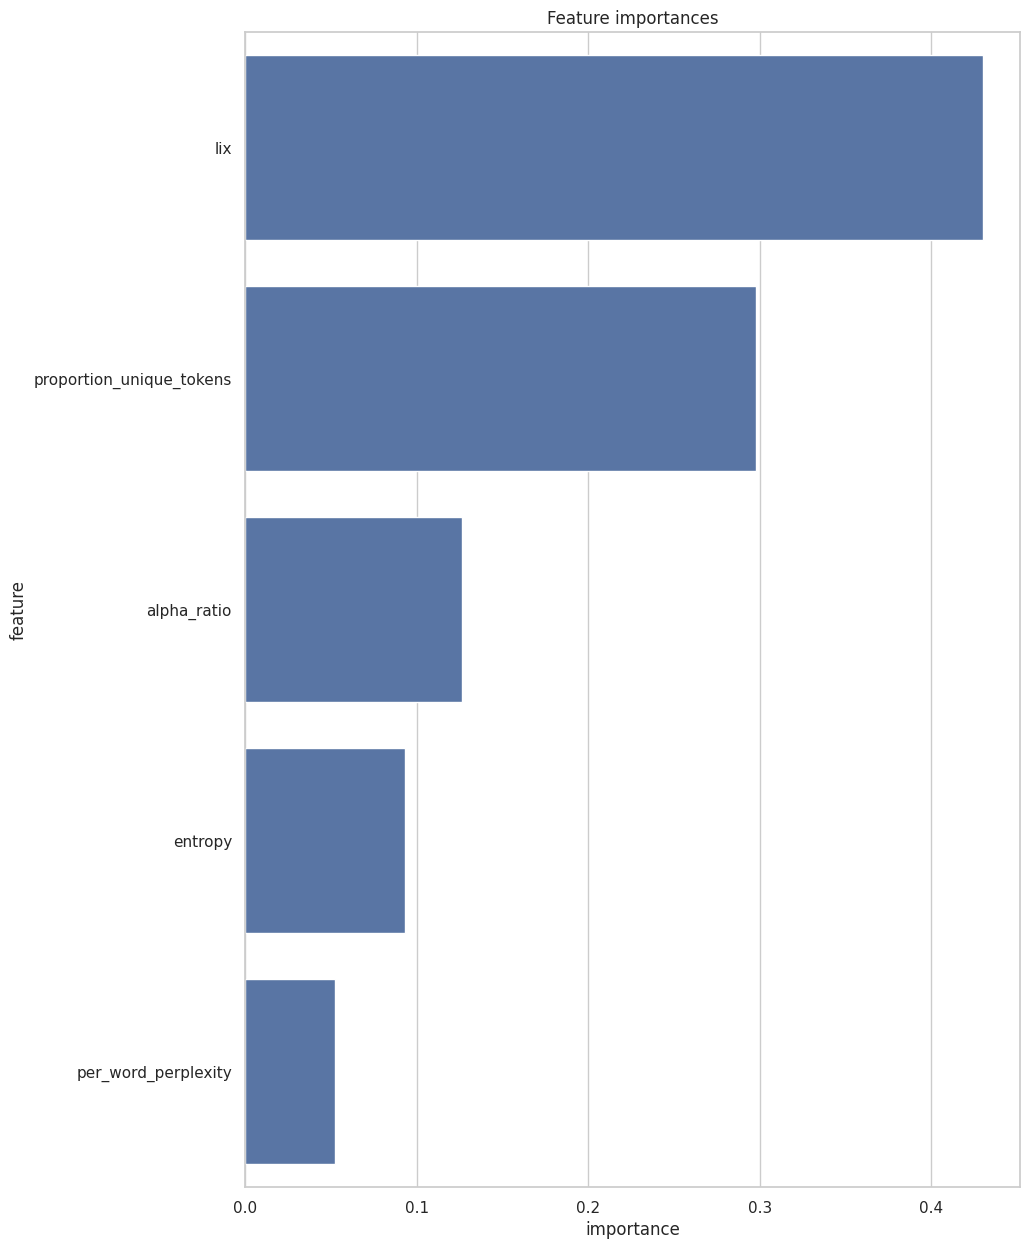

In [193]:
feature_importances, plot = show_feature_importances(clf, splits["X_train"])

## Imbalanced Dataset? 

In [194]:
# define funtion to check imbalance from splits dict 
def check_imbalance(ai_dir, human_dir, temp=1):
    # create dict for saving imbalances
    imbalance = {}

    for dataset in ["stories", "mrpc", "dailydialog", "dailymail_cnn"]:
        df = load_metrics(human_dir=human_dir, ai_dir=ai_dir, dataset=dataset, temp=temp)
        splits = create_split(df, random_state=129, val_test_size=0.15, outcome_col="is_human", verbose=False)
        
        # dict with counts for each split
        imbalance[dataset] = {'train': splits['y_train'].value_counts(),
                              'val': splits['y_val'].value_counts(),
                              'test': splits['y_test'].value_counts()}
        
    # convert to df 
    imbalance_df = pd.DataFrame.from_dict({(dataset, split): imbalance[dataset][split] for dataset in imbalance.keys() for split in imbalance[dataset].keys()}, orient='index')
    imbalance_df.index.names = ['Dataset', 'Split']
    imbalance_df.reset_index(inplace=True)

    return imbalance_df

In [195]:
imbalance_df = check_imbalance(human_dir=datapath / "human_metrics", 
                            ai_dir=datapath / "ai_metrics")
print(imbalance_df) # where 0 is ai and 1 is human

[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
[WARNING]: Loading only human completions... If you want to load 'source' metrics also, set human_completions_only=False.
[INFO:] Loading only AI data for temperature 1 ...
          Dataset  Split      0     1
0         stories  train  14000  3500
1         stories    val   3000   750
2         stories   test   3000   750
3            mrpc  train  10920  2730
4            mrpc    val   2340   585
5            mrpc   test   2340   585
6     dailydialog  train  14000  3500
7   

## Correlation Matrix

In [196]:
# filter irrelevant cols out
cols_to_drop = ["id", "unique_id", "sample_params", "temperature", "prompt_number", "contains_lorem ipsum"]
filtered_df = df.drop(cols_to_drop, axis=1)

In [197]:
corrM = filtered_df.corr()

/tmp/ipykernel_3102/3352751554.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrM = filtered_df.corr()


<Axes: >

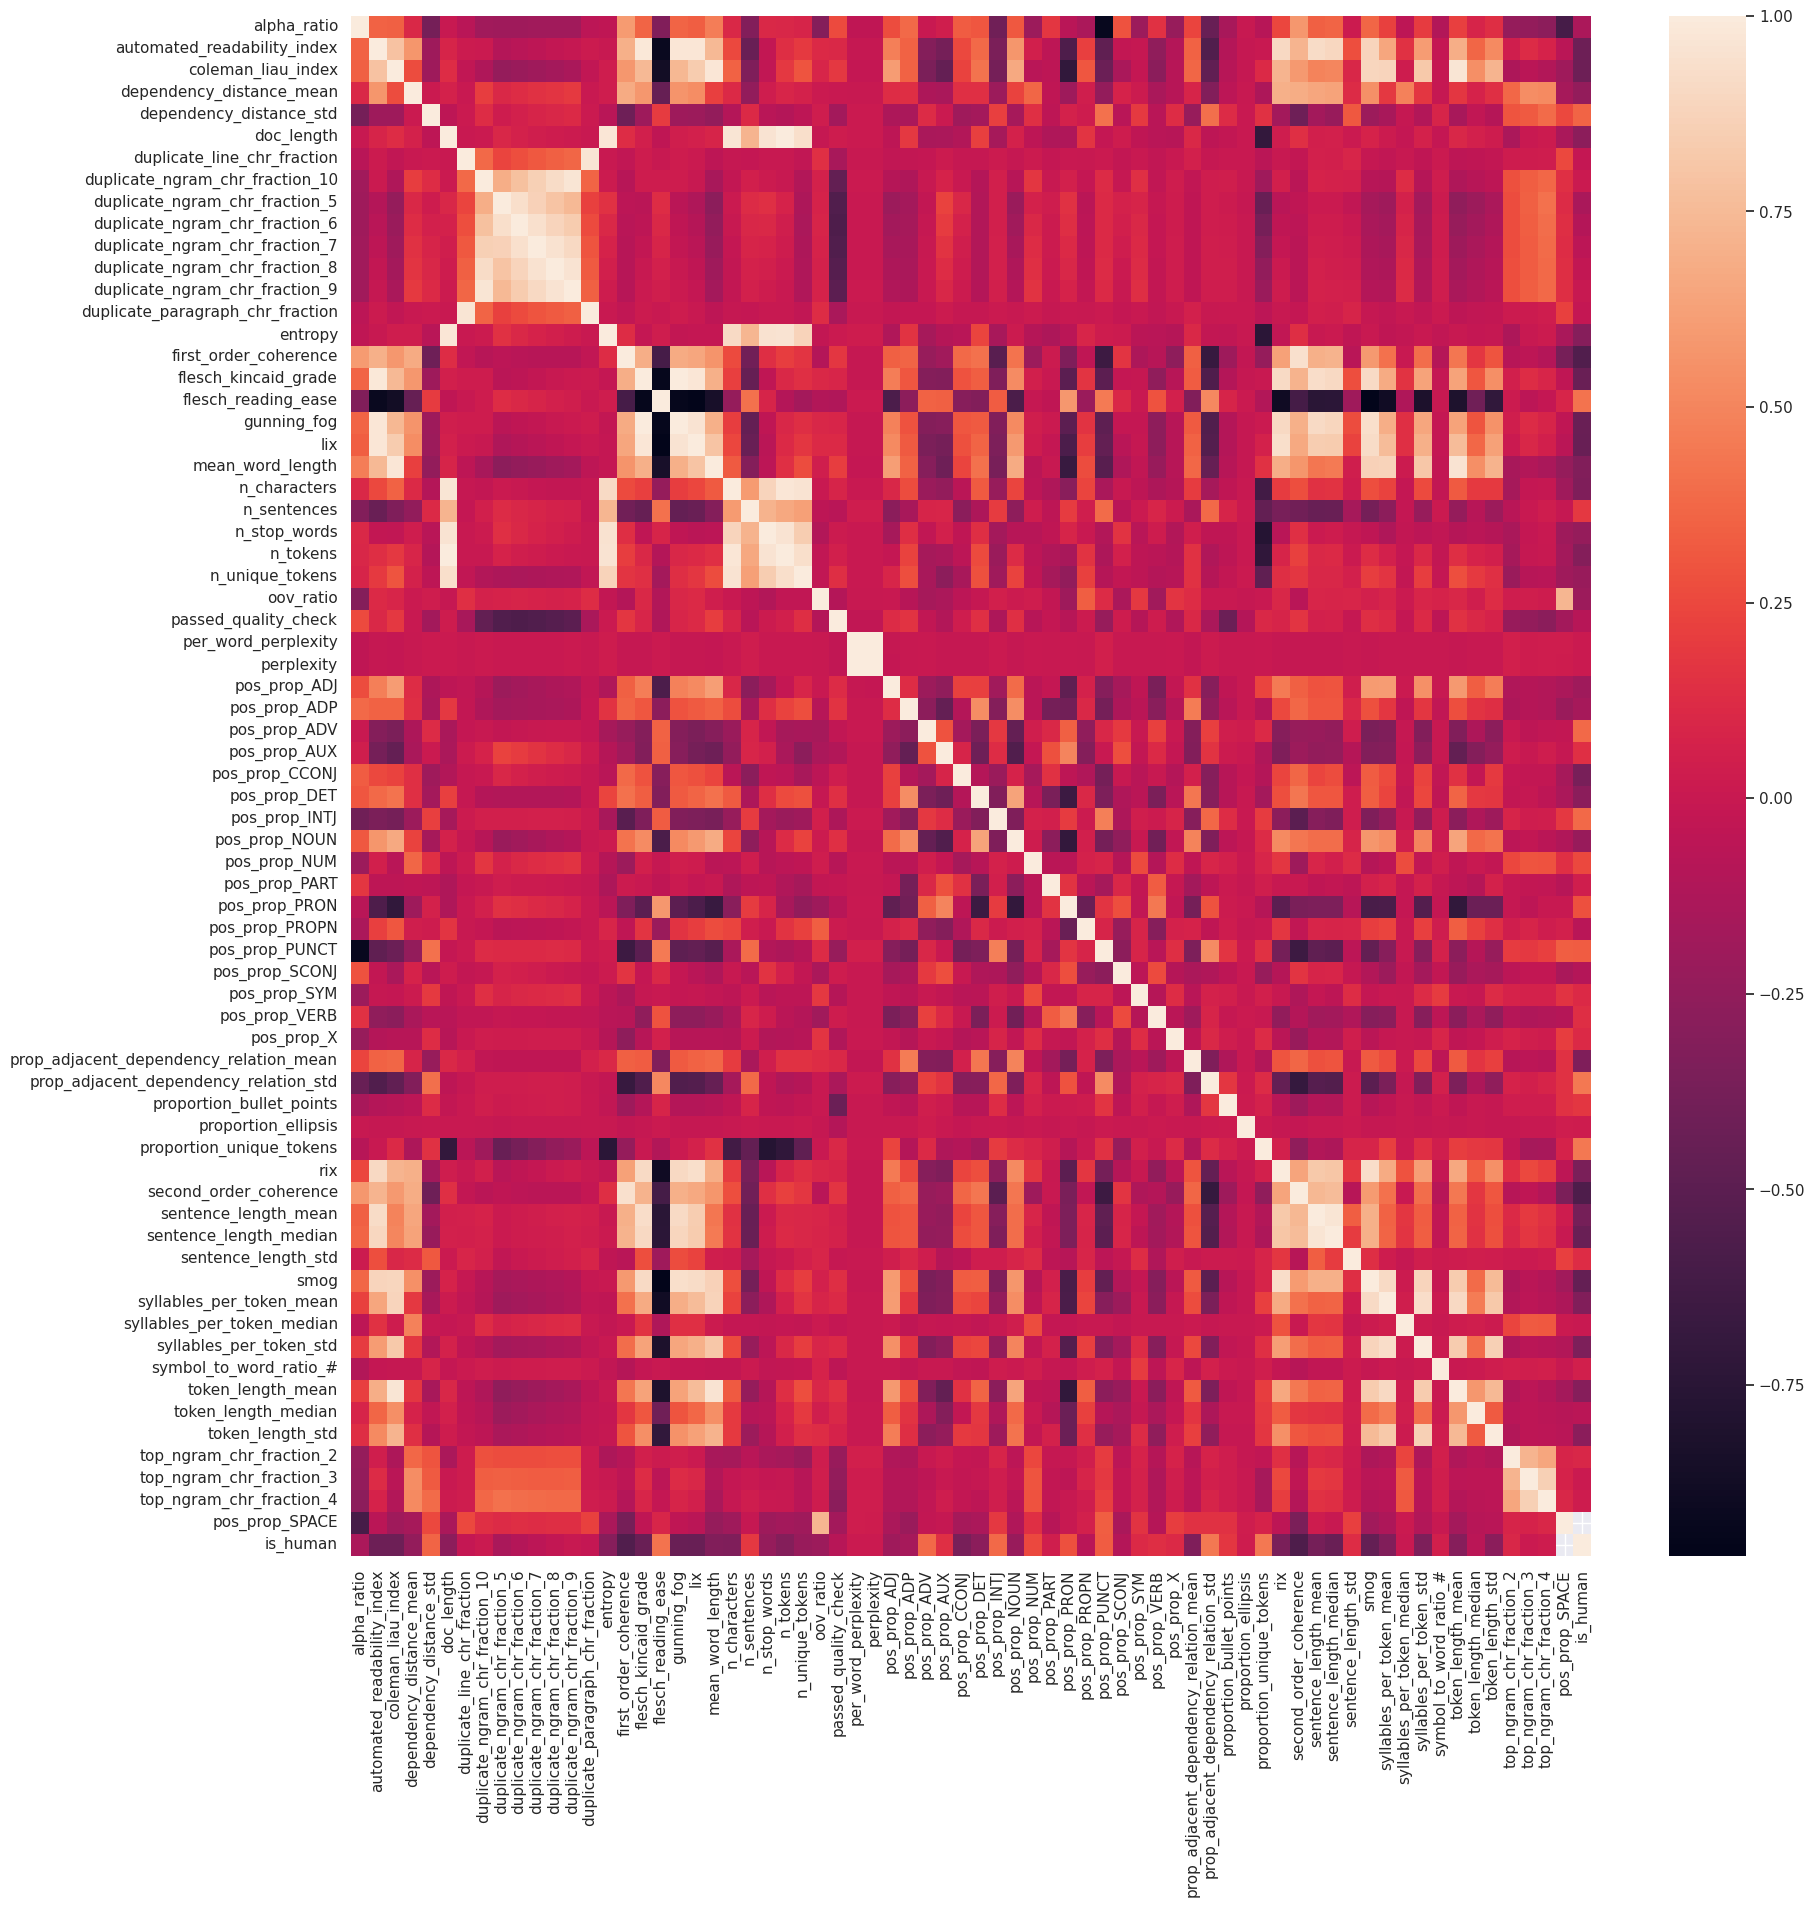

In [198]:
# drop nan
sns.set_theme(rc={'figure.figsize':(20, 20)})

# drop pos_prop_space as it is NA for is_human, then drop all other cols that is na (temporarily)
#corrM = corrM.drop("pos_prop_SPACE", axis=1) # can also just be done by specifying how = "all" in dropna as it will then only drop cols if all values are NA

sns.heatmap(corrM.dropna(how="all"))

In [199]:
test_df = df[["pos_prop_SPACE", "is_human", "model"]]
test_df

# check proportion of is_human that has pos_prop_SPACE as NA
test_df[test_df["pos_prop_SPACE"].isna()]["is_human"].value_counts()

1    5000
0       1
Name: is_human, dtype: int64

## Dimensionality Reduction

In [200]:
## DEFINE FEATURES ##
# get columns as list
cols = list(df.columns)

# take out some cols (outcome variable + some irrelevant cols)
cols_to_drop = ["model", "id", "is_human", "unique_id", "sample_params", "temperature", "prompt_number", "contains_lorem ipsum", "dataset", "pos_prop_SPACE"]

# drop cols
for col in cols_to_drop:
    cols.remove(col)

print(cols)

# filter df to only include relevant cols
filtered_df = df[cols]

# rm NA
filtered_df = filtered_df.dropna()

print(len(filtered_df.columns))

['alpha_ratio', 'automated_readability_index', 'coleman_liau_index', 'dependency_distance_mean', 'dependency_distance_std', 'doc_length', 'duplicate_line_chr_fraction', 'duplicate_ngram_chr_fraction_10', 'duplicate_ngram_chr_fraction_5', 'duplicate_ngram_chr_fraction_6', 'duplicate_ngram_chr_fraction_7', 'duplicate_ngram_chr_fraction_8', 'duplicate_ngram_chr_fraction_9', 'duplicate_paragraph_chr_fraction', 'entropy', 'first_order_coherence', 'flesch_kincaid_grade', 'flesch_reading_ease', 'gunning_fog', 'lix', 'mean_word_length', 'n_characters', 'n_sentences', 'n_stop_words', 'n_tokens', 'n_unique_tokens', 'oov_ratio', 'passed_quality_check', 'per_word_perplexity', 'perplexity', 'pos_prop_ADJ', 'pos_prop_ADP', 'pos_prop_ADV', 'pos_prop_AUX', 'pos_prop_CCONJ', 'pos_prop_DET', 'pos_prop_INTJ', 'pos_prop_NOUN', 'pos_prop_NUM', 'pos_prop_PART', 'pos_prop_PRON', 'pos_prop_PROPN', 'pos_prop_PUNCT', 'pos_prop_SCONJ', 'pos_prop_SYM', 'pos_prop_VERB', 'pos_prop_X', 'prop_adjacent_dependency_rela

In [201]:
# run pca with all features
pca, pca_df = run_PCA(filtered_df, feature_names=cols, n_components=len(cols))

In [202]:
# make table of pc components and explained variance
explained_variance = pca.explained_variance_ratio_

# make explained variance without scientific notation
explained_variance = ["{:.2f}".format(i) for i in explained_variance]

# create df
pca_df = pd.DataFrame({"PC": range(1, len(explained_variance)+1), "Explained variance": explained_variance})

print(pca_df)

    PC Explained variance
0    1               0.27
1    2               0.11
2    3               0.09
3    4               0.07
4    5               0.04
5    6               0.04
6    7               0.03
7    8               0.03
8    9               0.02
9   10               0.02
10  11               0.02
11  12               0.02
12  13               0.02
13  14               0.01
14  15               0.01
15  16               0.01
16  17               0.01
17  18               0.01
18  19               0.01
19  20               0.01
20  21               0.01
21  22               0.01
22  23               0.01
23  24               0.01
24  25               0.01
25  26               0.01
26  27               0.01
27  28               0.01
28  29               0.01
29  30               0.01
30  31               0.01
31  32               0.01
32  33               0.01
33  34               0.00
34  35               0.00
35  36               0.00
36  37               0.00
37  38      

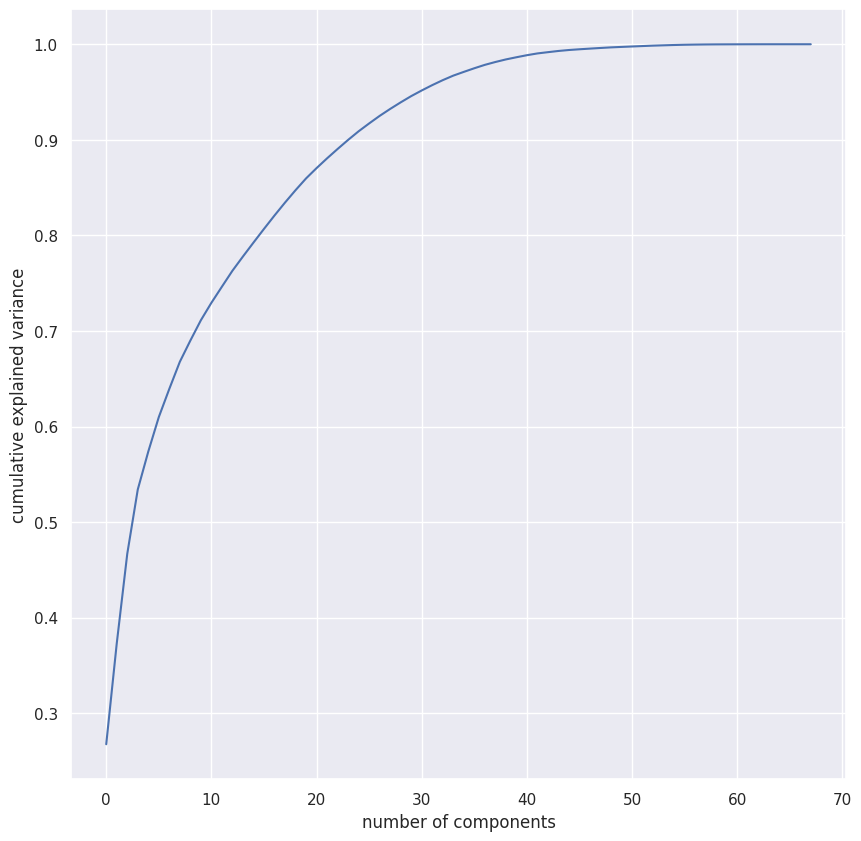

In [203]:
sns.set_theme(rc={'figure.figsize':(10, 10)}) # see https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [204]:
# see stack overflow https://stackoverflow.com/questions/67585809/how-to-map-the-results-of-principal-component-analysis-back-to-the-actual-featur
PCnames = ['PC'+str(i+1) for i in range(pca.n_components_)]
loadings = pd.DataFrame(pca.components_,columns=PCnames,index=filtered_df.columns)

# get the first 4 components for the first 5 rows from loadings
print("Printing a subset of the loadings ..")
loadings.iloc[:5, :4]

Printing a subset of the loadings ..


,PC1,PC2,PC3,PC4
alpha_ratio,0.117164,0.224873,0.218127,0.153232
automated_readability_index,-0.020294,0.008225,-0.014928,0.058634
coleman_liau_index,-0.056799,0.056818,0.011686,0.081050
dependency_distance_mean,-0.297656,-0.009163,0.100736,-0.119784
dependency_distance_std,-0.015633,0.025327,-0.079772,0.146618


<Axes: >

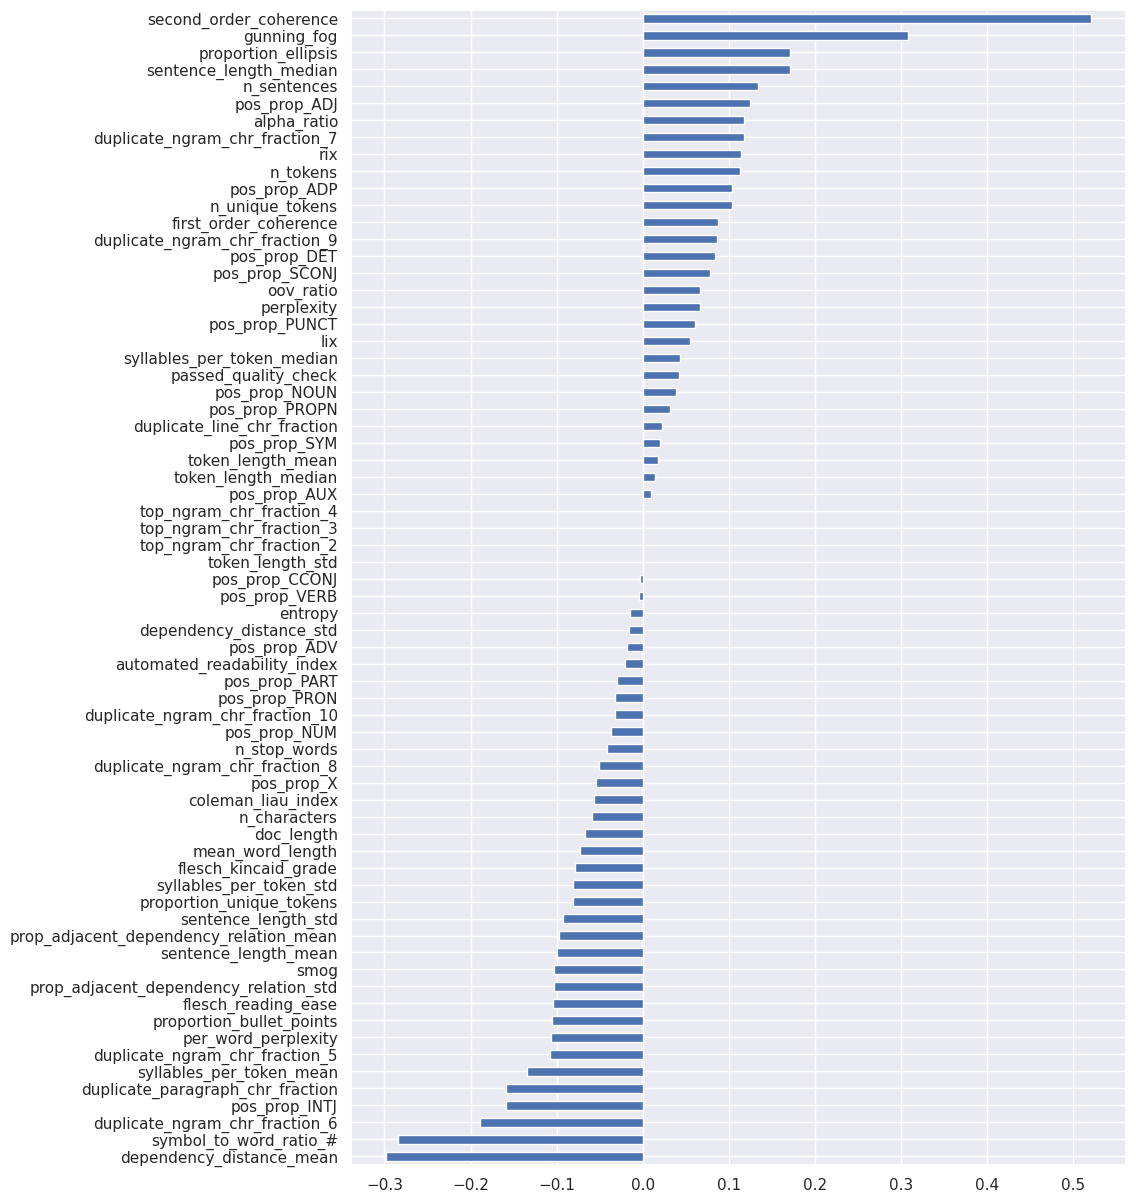

In [205]:
# see stack overflow https://stackoverflow.com/questions/67585809/how-to-map-the-results-of-principal-component-analysis-back-to-the-actual-featur
sns.set_theme(rc={'figure.figsize':(10, 15)})
loadings["PC1"].sort_values().plot.barh()